In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../datasets/PXD002099/'
setwd(data_folder)

In [4]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()

1892


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=10 fmol,1,1,5461842.0,110616_yeast_ups_10fmol.mzML
1,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=25 fmol,2,4,3025948.0,110618_yeast_ups_25fmol_r1.mzML
2,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=25 fmol,2,5,3061254.0,110618_yeast_ups_25fmol_r2.mzML
3,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=25 fmol,2,6,4087644.0,110618_yeast_ups_25fmol_r3.mzML
4,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=50 fmol,3,7,2912077.0,110618_yeast_ups_50fmol_r1.mzML


#### overlap of quantified proteins

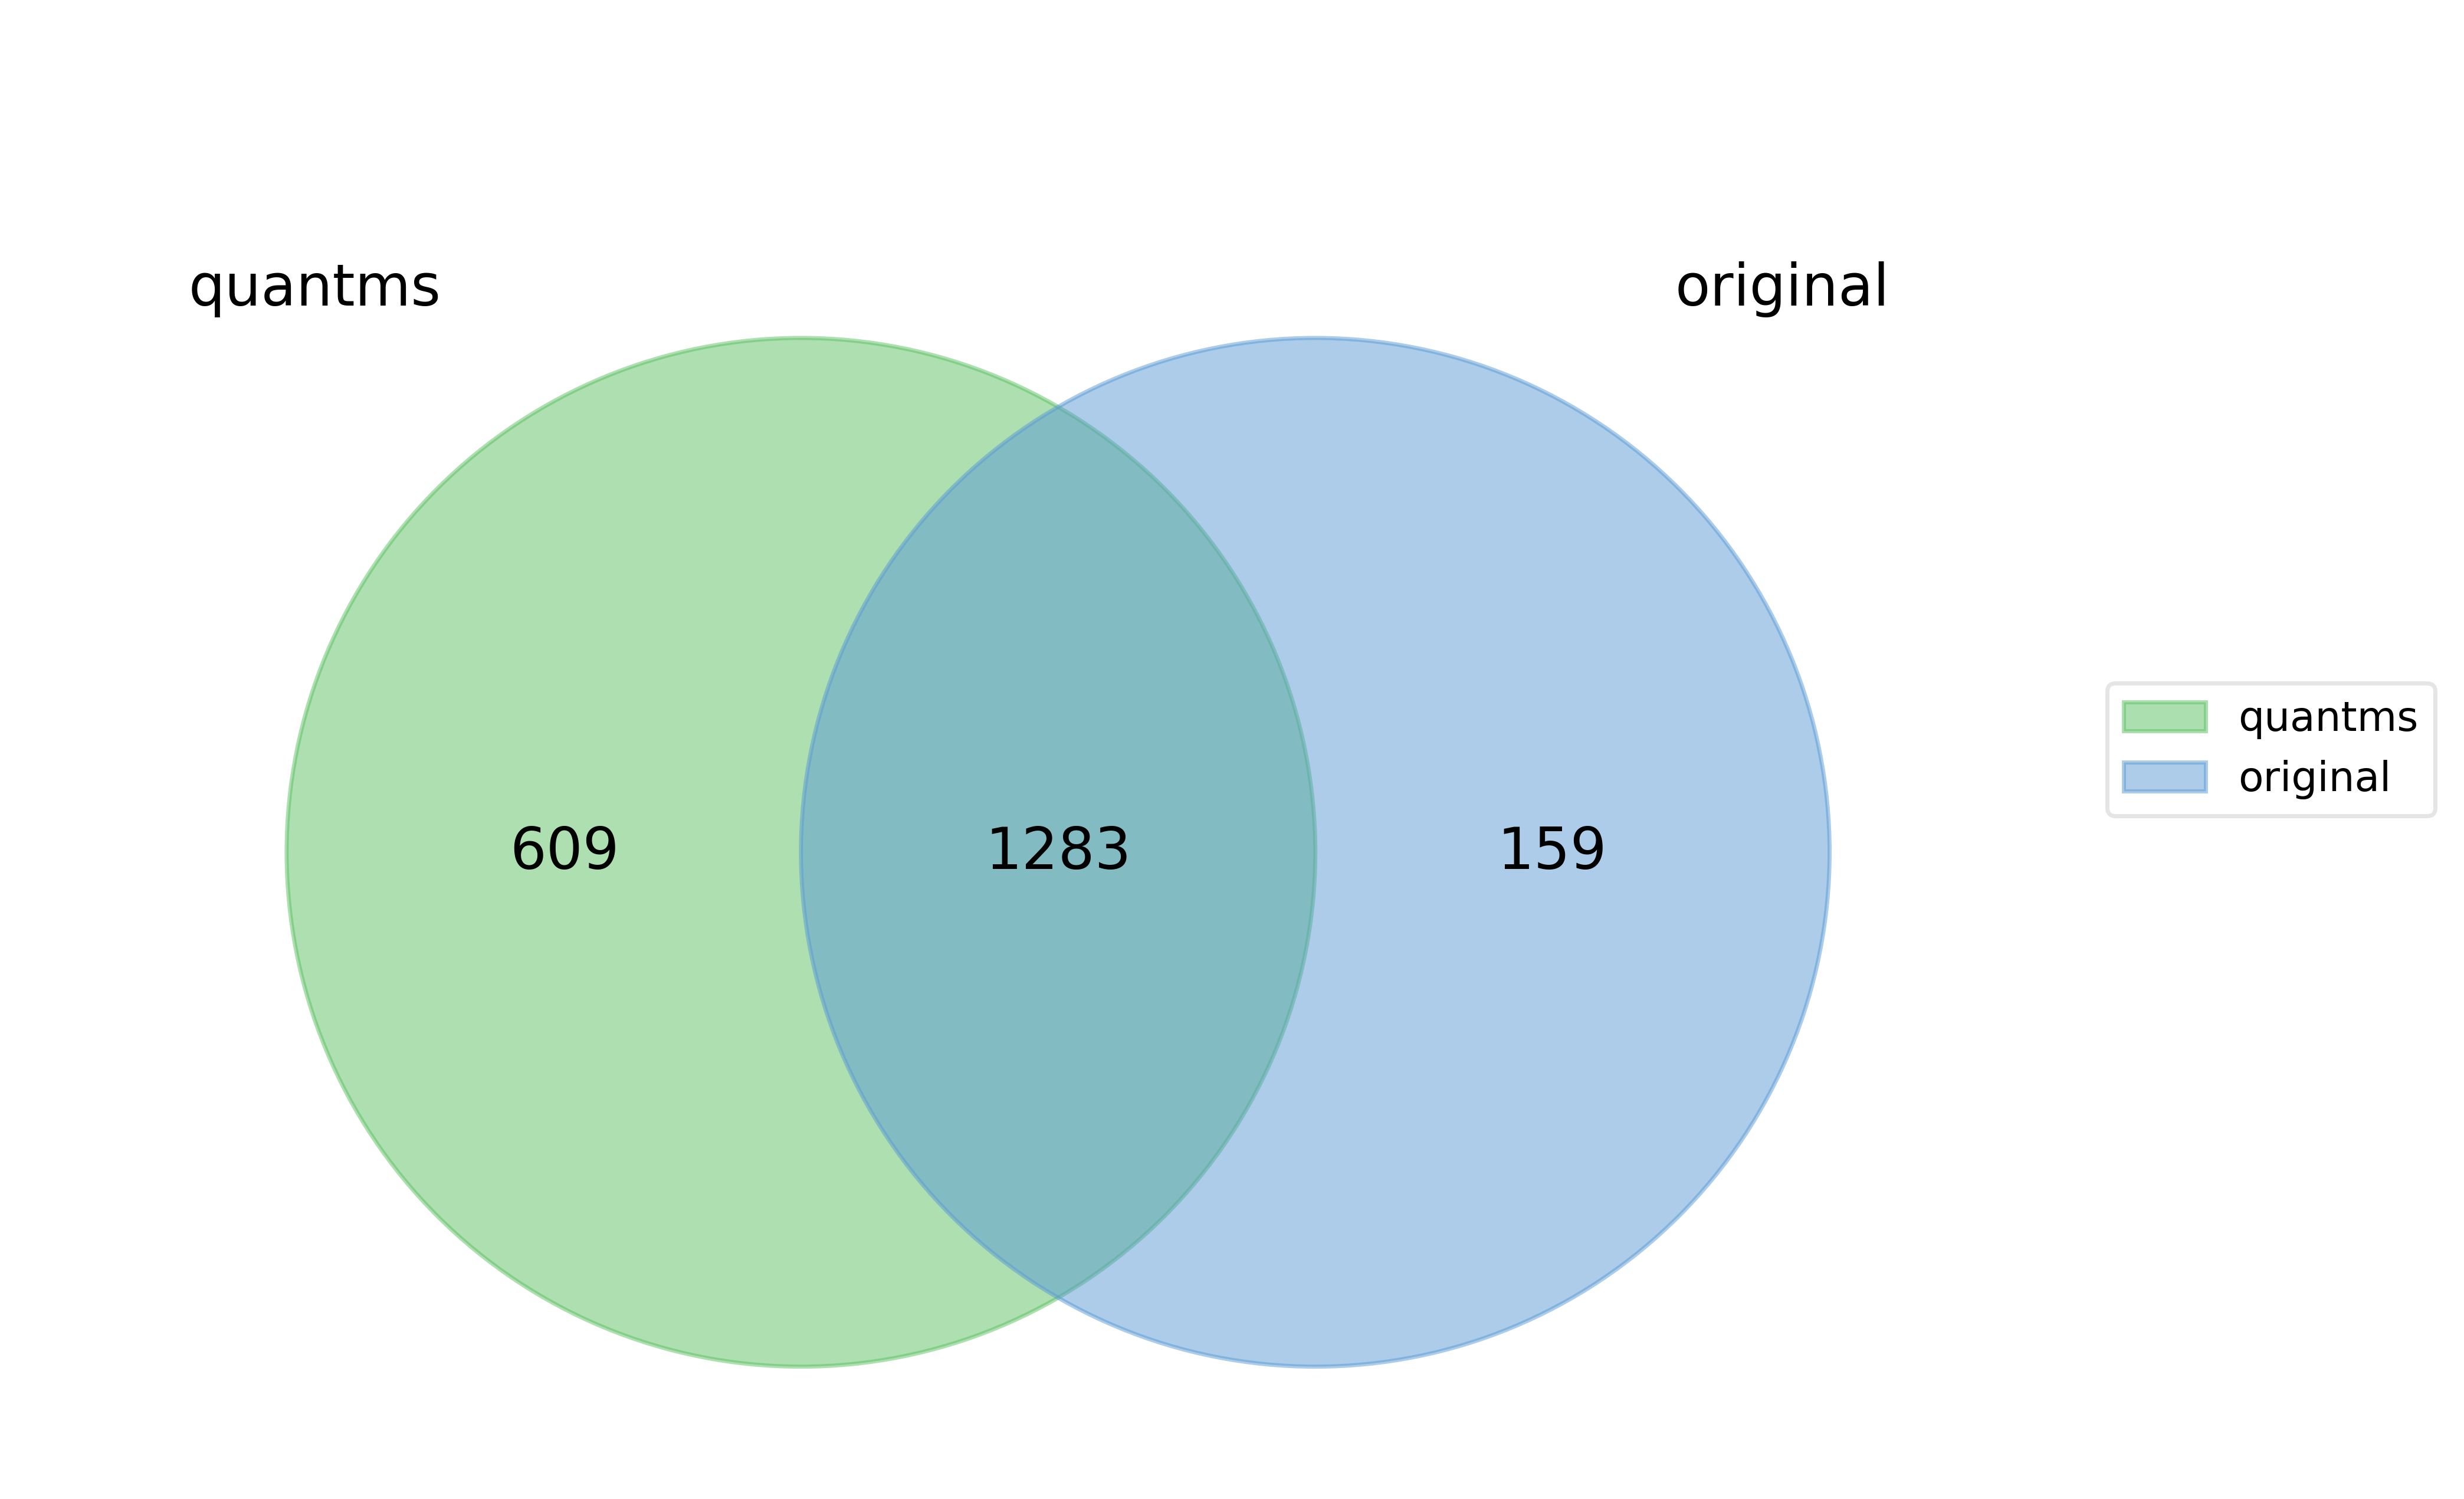

In [8]:
from pyvenn import venn
quantms['P1'] = quantms.apply(lambda x: ";".join(x['ProteinName'].split("|")[1::2]), axis=1)

original = pd.read_csv('YEAST-Data-NonNormalized.csv', sep=";", header=0)
labels = venn.get_labels([set(quantms['P1']), set(original['Accession'])], fill=['number'])
fig, ax = venn.venn2(labels, names=['quantms', 'original'], dpi=500)
plt.show()

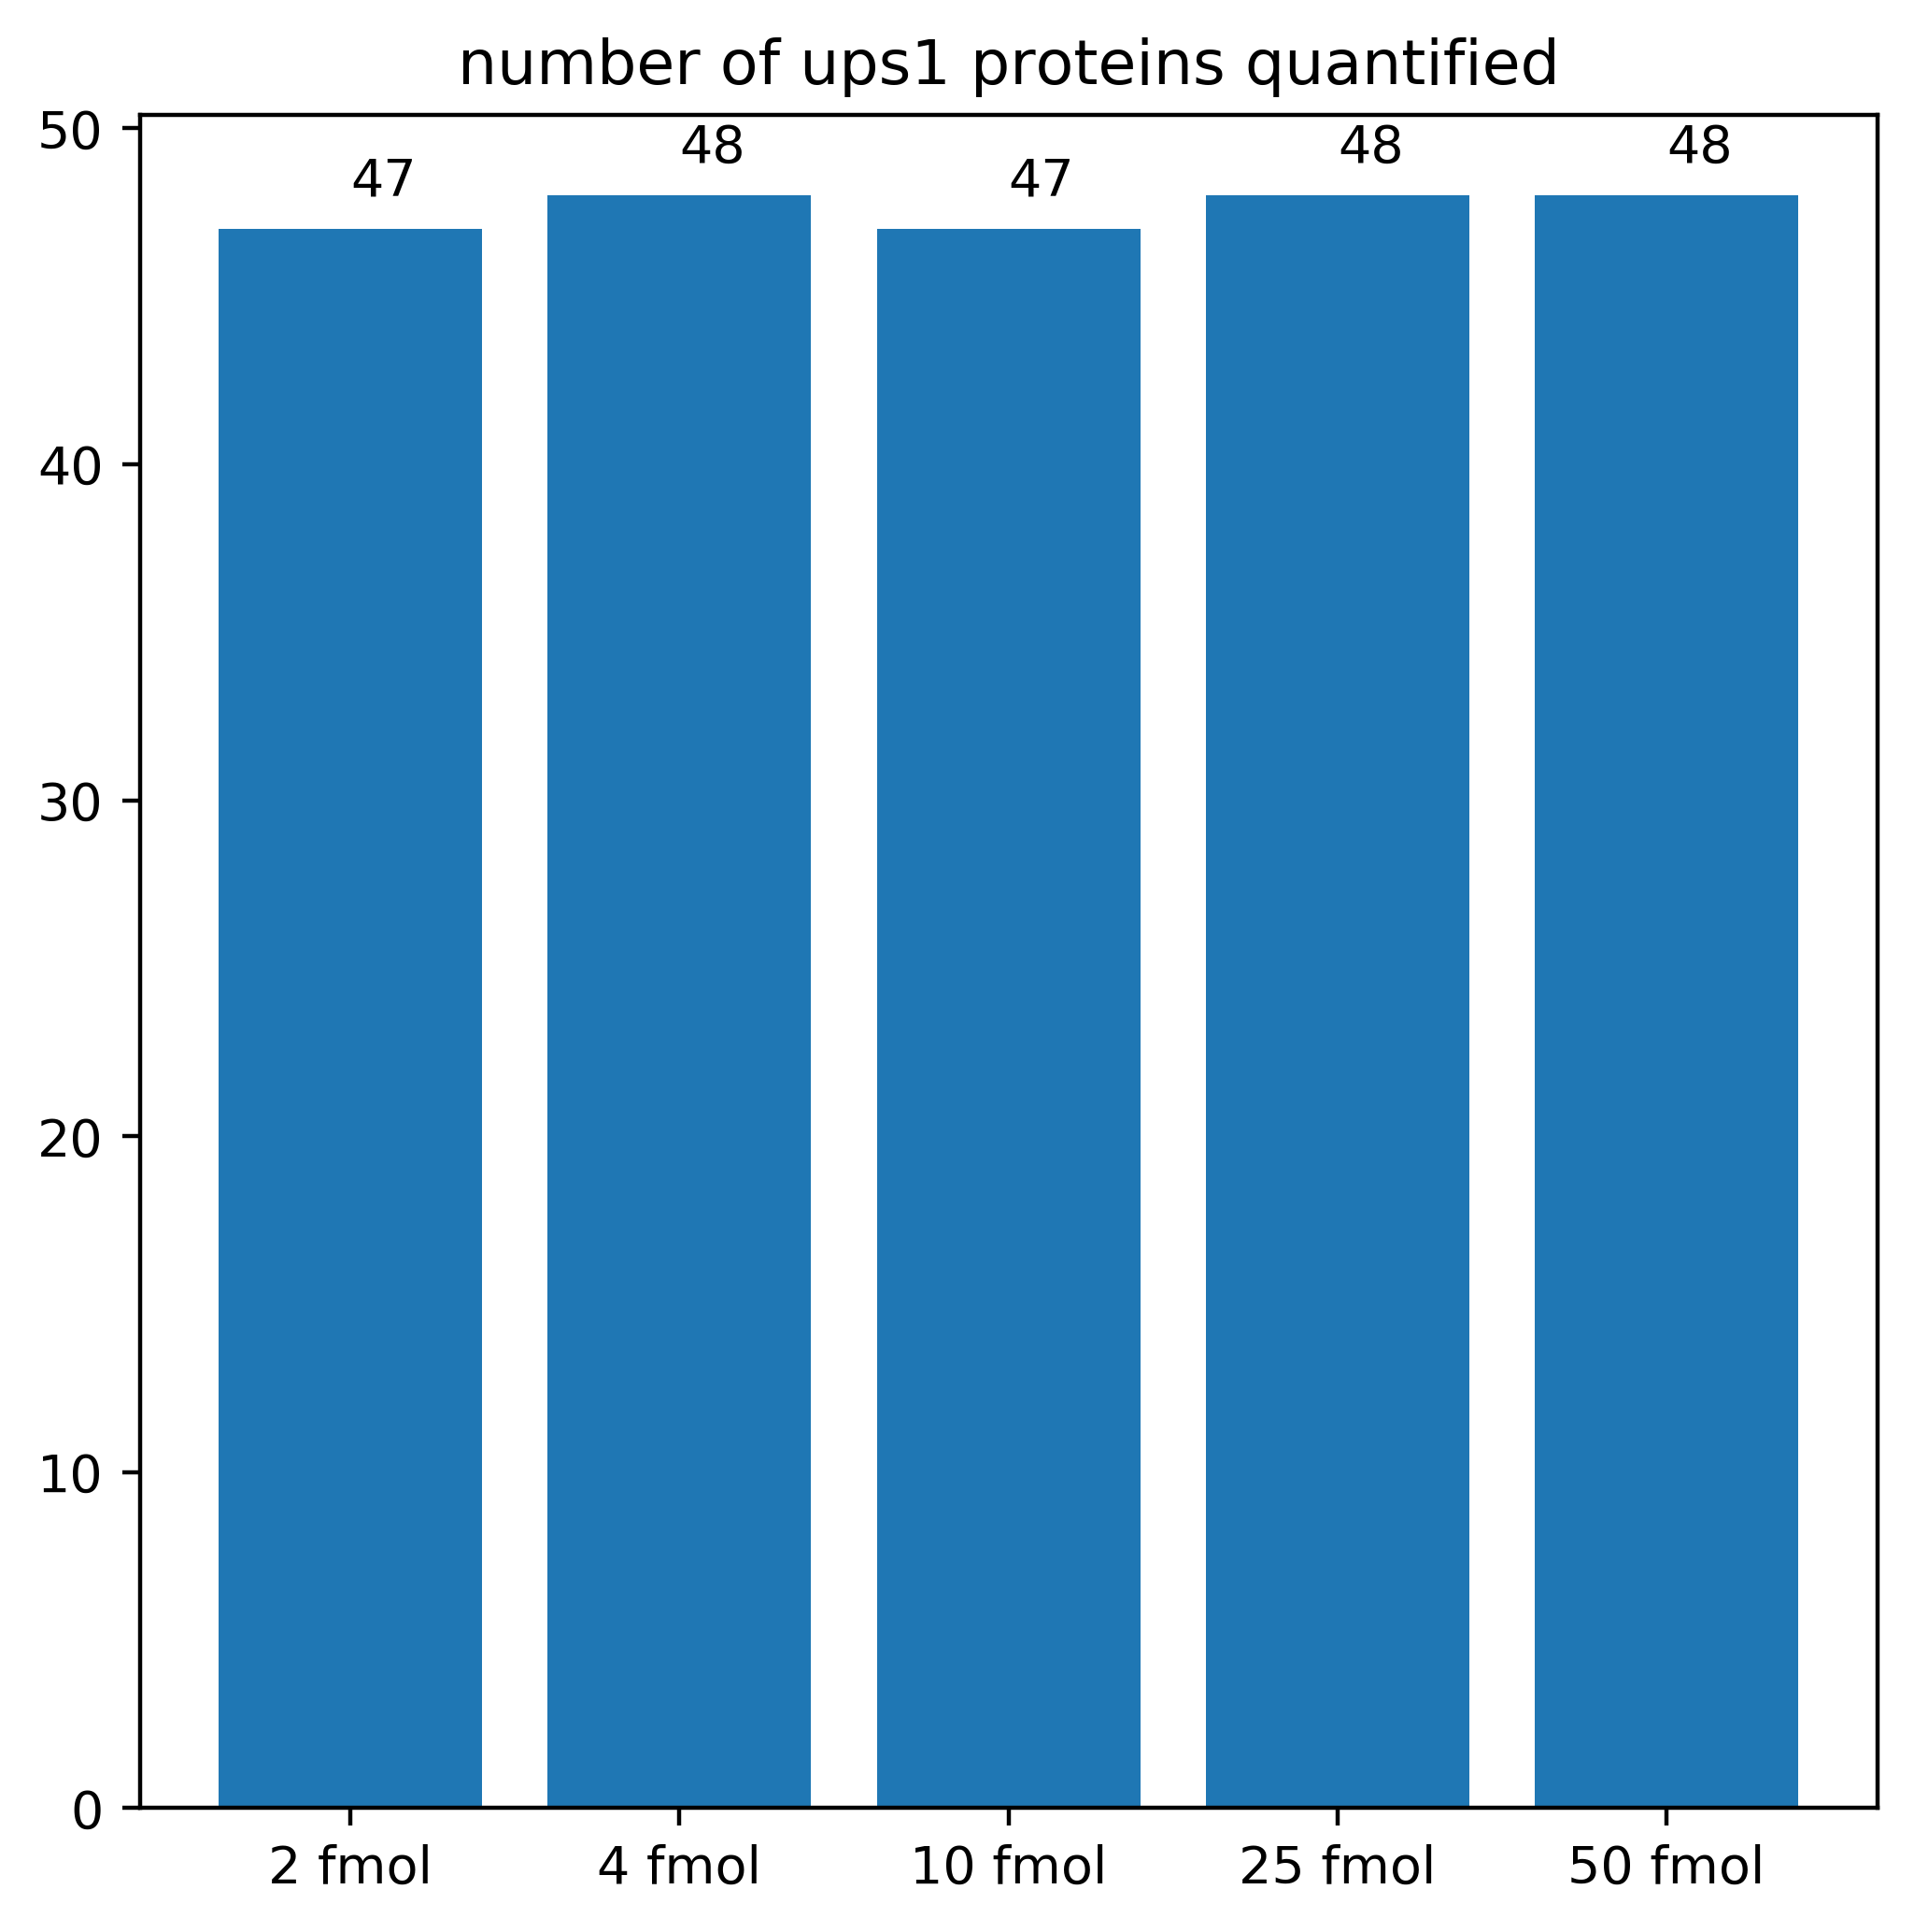

In [10]:
number_of_ups1 = dict()
for condition in np.unique(quantms['Condition']):
    number_of_ups1[condition.replace("CT=Mixture;CN=UPS1;QY=", "")] = len((set(quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition), 'ProteinName'])))

plt.figure(figsize=(6,6), dpi=400)
num = []
label = []
for key, value in sorted(number_of_ups1.items(), key=lambda item: int(item[0].replace("fmol",""))):
    num.append(value)
    label.append(key)
for x, y in zip(range(5), num):
    plt.text(x, y+1, y)

plt.bar(range(5), num)
plt.title("number of ups1 proteins quantified")
plt.xticks(range(5),label)
plt.show()

### Reproducibility between Analytical Replicate before msstats process

#### UPS1 CV . Filtered out missing ups1 protein but not fill or Imputation

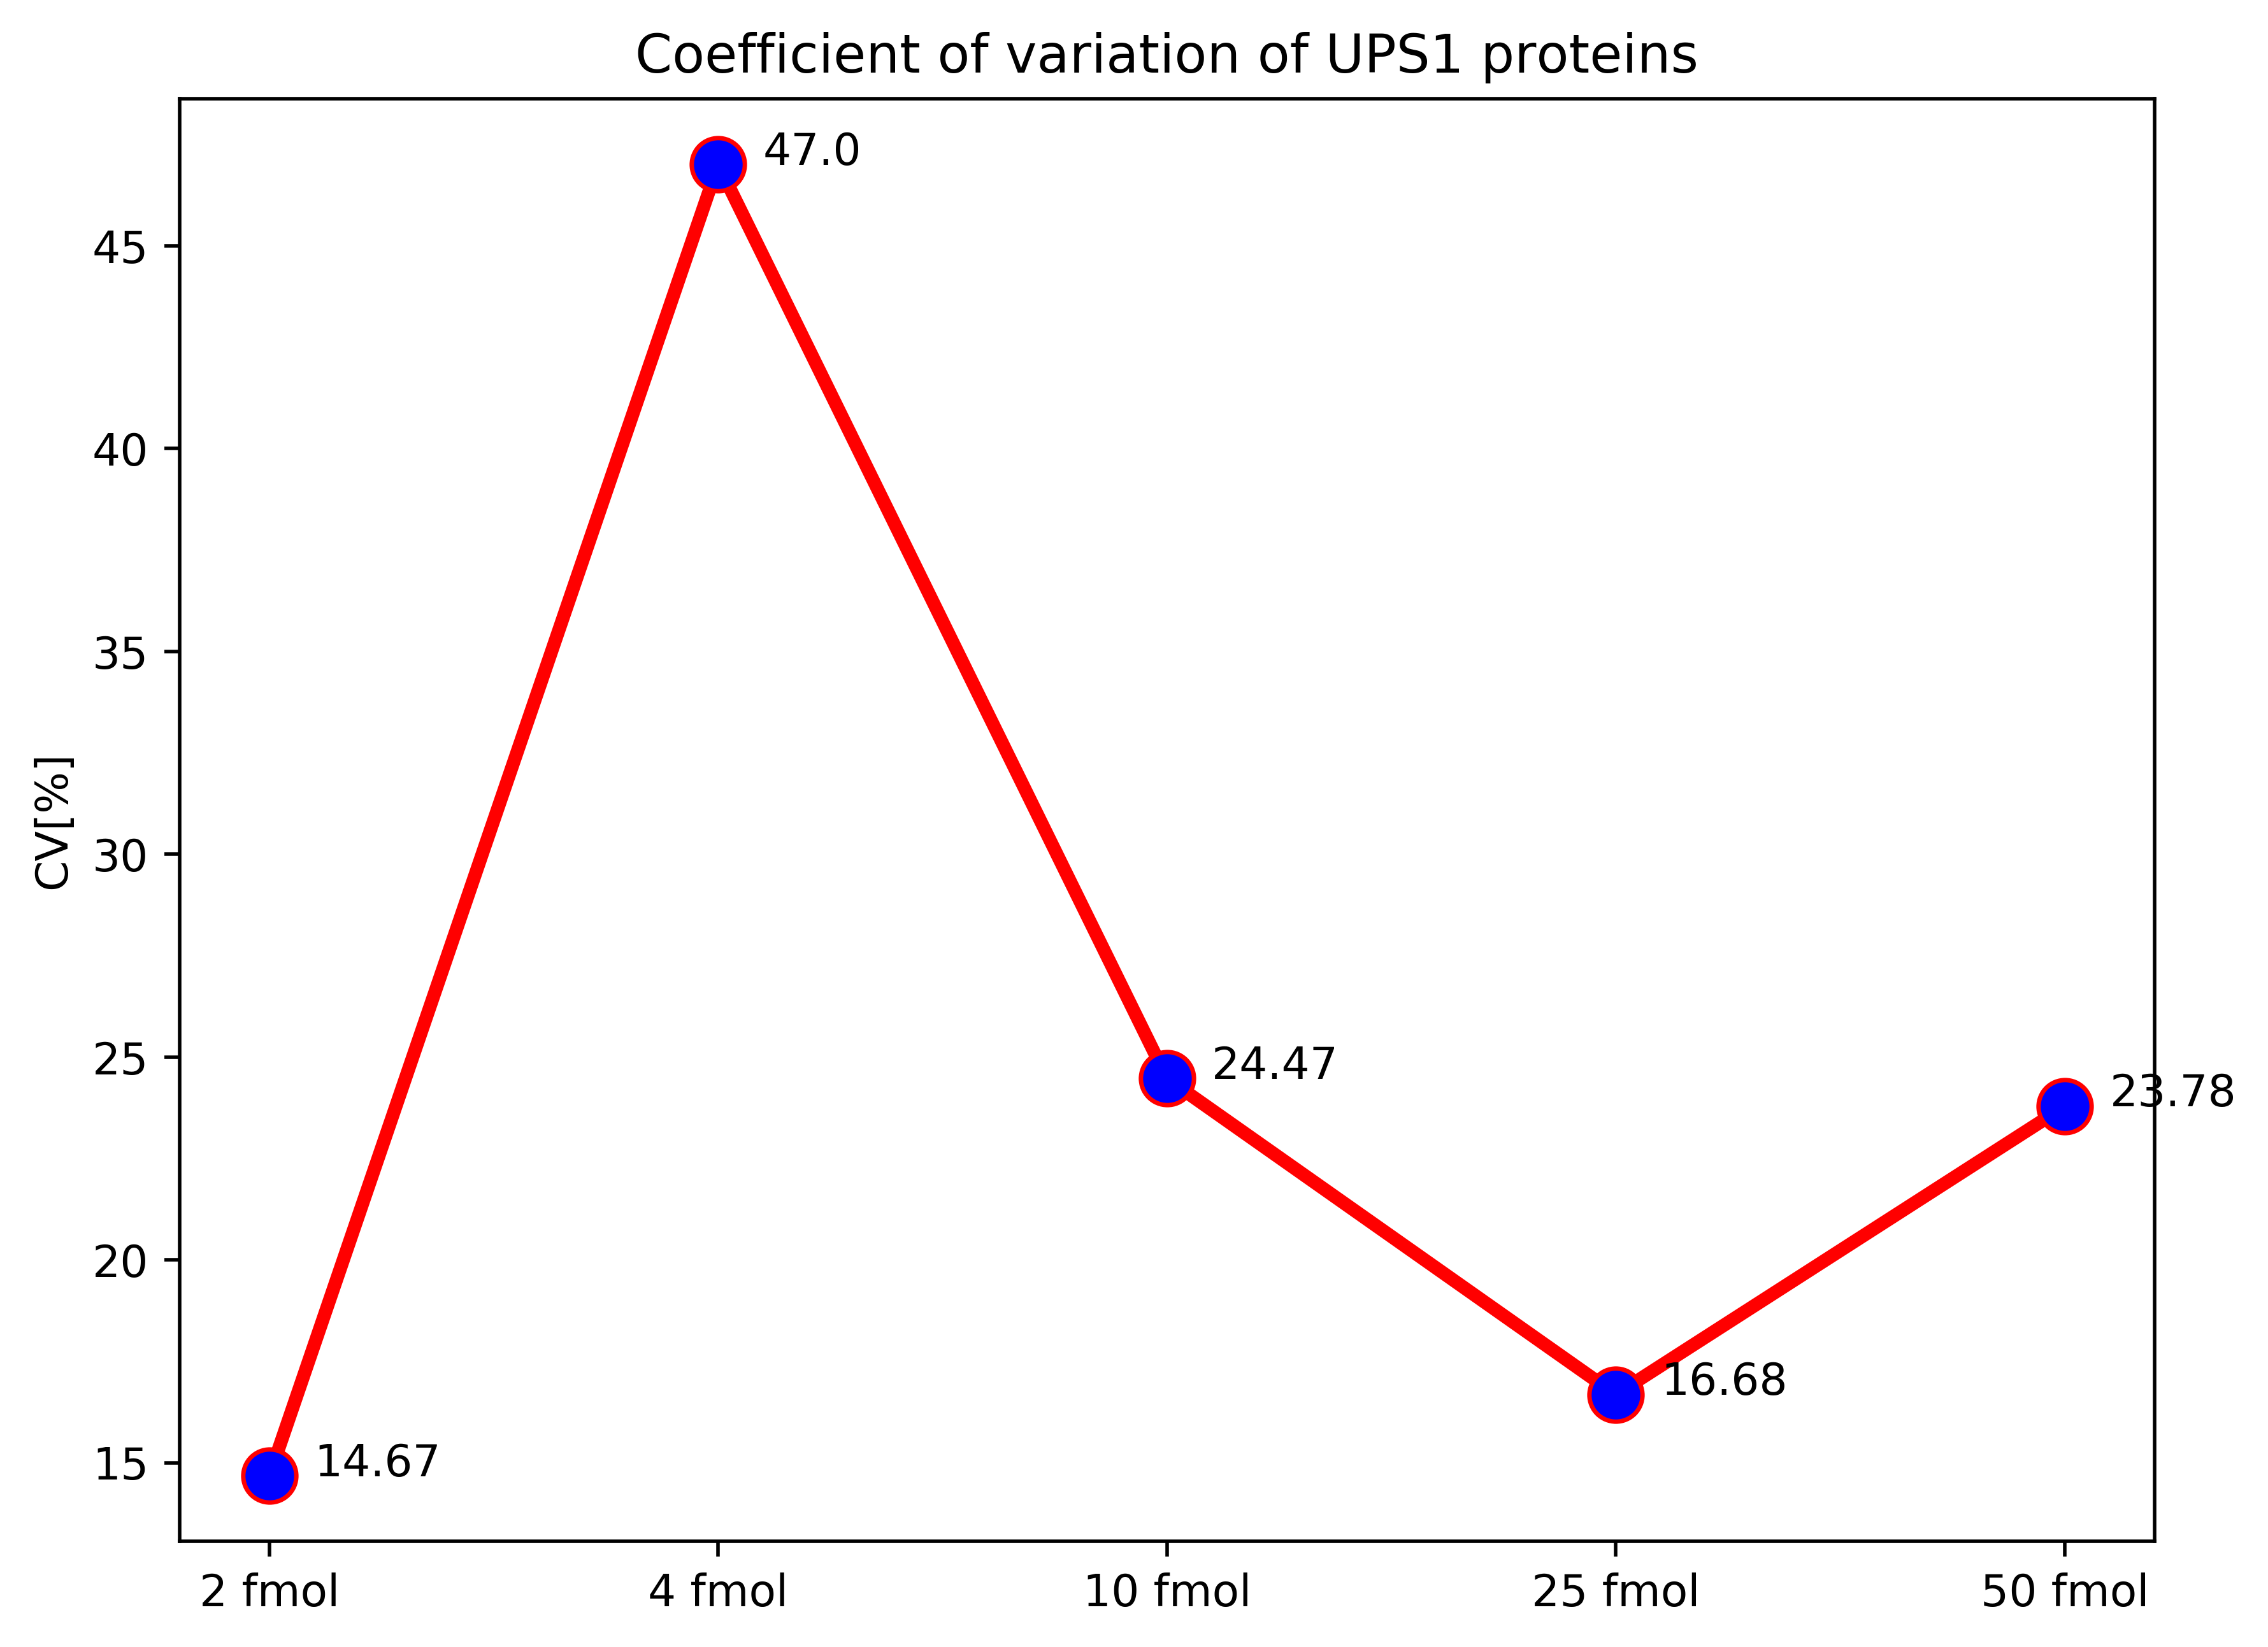

In [14]:
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
for condition in np.unique(quantms['Condition']):
    if len(quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]) < 3:
        continue
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            tech_intensity.append(np.sum(quant_condition[(quant_condition['ProteinName'] == protein) & ((quant_condition['Run'] == run))]['Intensity']))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        n_data = n_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: int(x.replace("CT=Mixture;CN=UPS1;QY=","").replace("fmol", "")))
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    xticks.append(condition.replace("CT=Mixture;CN=UPS1;QY=",""))
    
plt.plot(range(5), cvs, linewidth=3, color='r', marker='o',markerfacecolor='blue', markersize=12)
plt.xticks(range(5), xticks)
for i in range(5):
    plt.text(i+0.1, cvs[i], round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of UPS1 proteins')
plt.show()

#### Calcaulate CV of backgroud Proteins

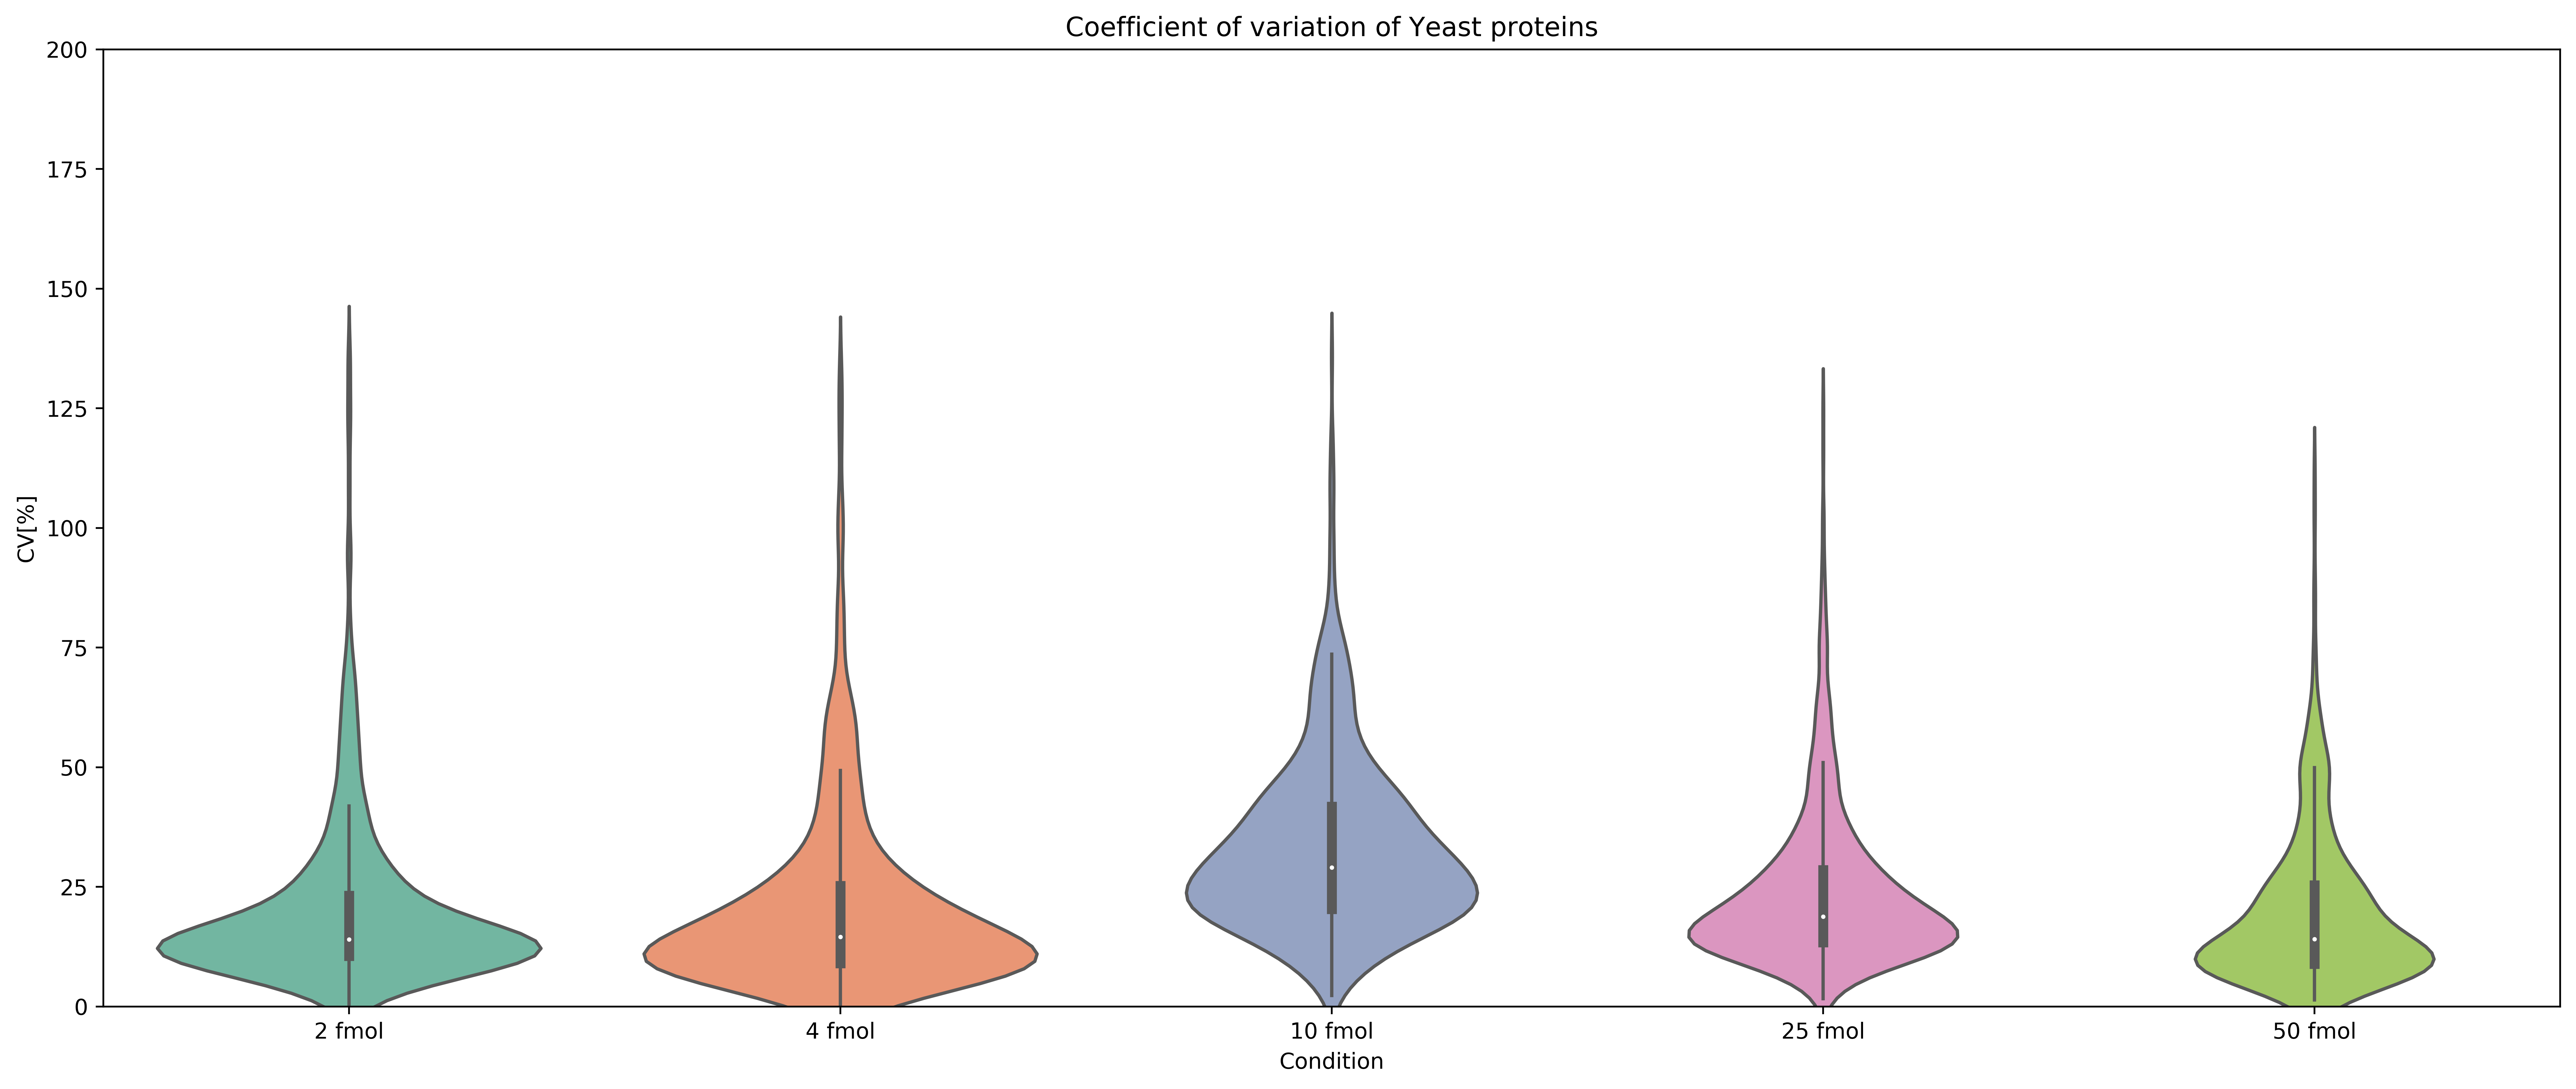

In [17]:
b_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
quantms_background = quantms[-quantms['ProteinName'].str.contains("UPS")]
for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
    for protein in np.unique(quantms_background_condition['ProteinName']):
        msruns = np.unique(quantms_background_condition[quantms_background_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            tech_intensity.append(np.sum(quantms_background_condition[(quantms_background_condition['ProteinName'] == protein) & ((quantms_background_condition['Run'] == run))]['Intensity']))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        b_data = b_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition.replace("CT=Mixture;CN=UPS1;QY=",""), "CV[%]": 100 * (std / mean)}, ignore_index=True)

plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of Yeast proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=b_data, scale= "count", palette="Set2", 
               order=['2 fmol', '4 fmol', '10 fmol', '25 fmol', '50 fmol'])

plt.show()

### QCplots and Calculate FC

In [24]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
library("dplyr")
#library(reticulate)

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om$Condition <- sub("CT=Mixture;CN=UPS1;QY=", "", raw.om$Condition)

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-12-02 21:17:00] ** Features with one or two measurements across runs are removed.
INFO  [2021-12-02 21:17:00] ** Fractionation handled.
INFO  [2021-12-02 21:17:00] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-12-02 21:17:00] ** Log2 intensities under cutoff = 15.042  were considered as censored missing values.
INFO  [2021-12-02 21:17:00] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-12-02 21:17:00] ** Use all features that the dataset originally has.
INFO  [2021-12-02 21:17:01] 
 # proteins: 1625
 # peptides per protein: 1-101
 # features per peptide: 1-1
INFO  [2021-12-02 21:17:01] Some proteins have only one feature: 
 P62988ups|UBIQ_HUMAN_UPS,
 sp|O13516|RS9A_YEAST,
 sp|O13585|YP089_YEAST,
 sp|O43137|YB085_YEAST,
 sp|P00724|INV2_YEAST ...
INFO  [2021-12-02 21:17:01] 
                    10 fmol 2 fmol 25 fmol 4 fmol 50 fmol
             # runs       3      3       3      3       3
 

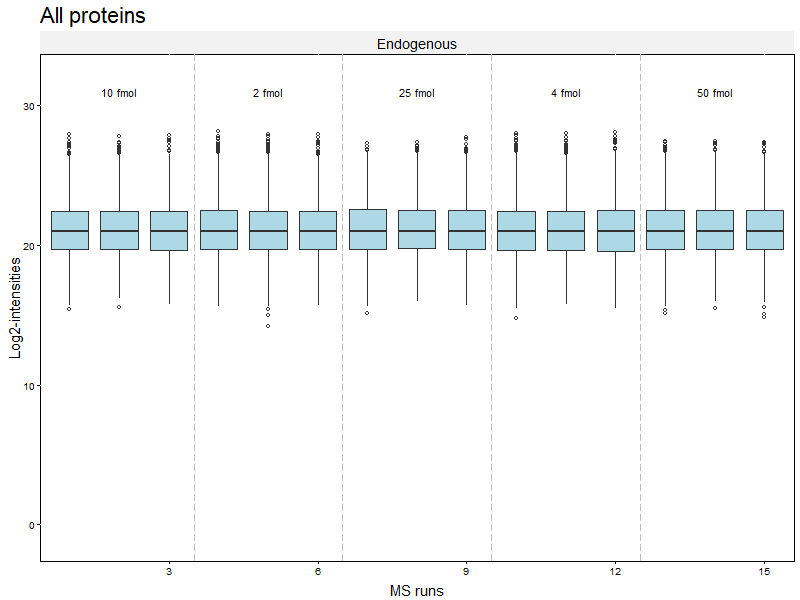

In [25]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

[1] "sp|P23201|SPA2_YEAST"
  |===================                                                   |  26%


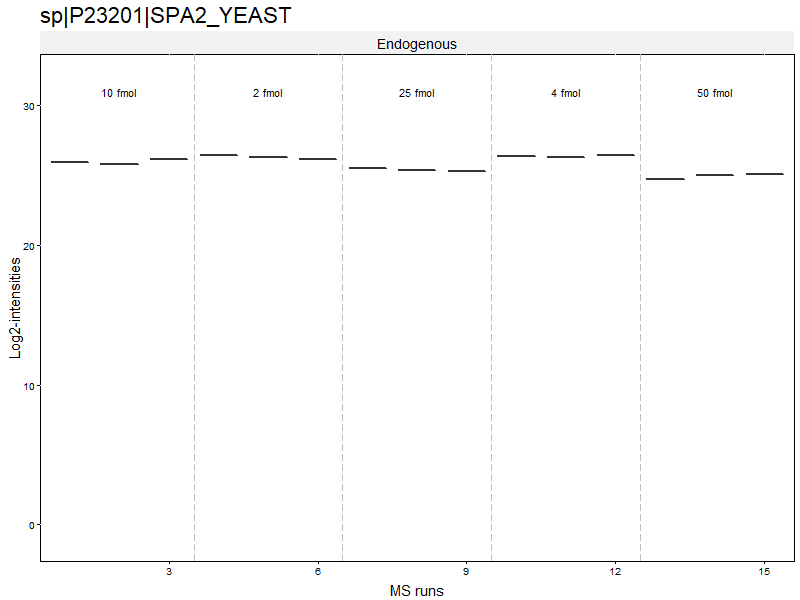

In [26]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

#### background proteins: Intensity shoud be identical in all MSrun

  |======================================================================| 100%
  |======================================================================| 100%


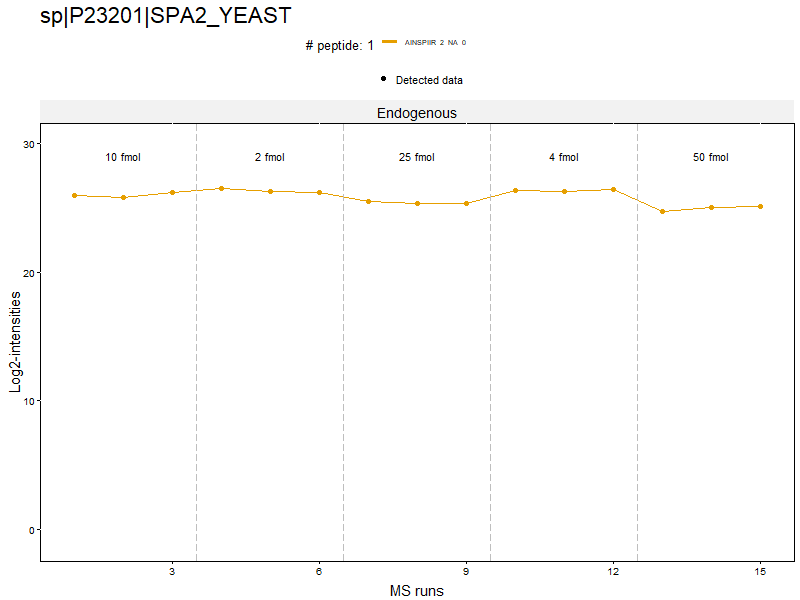

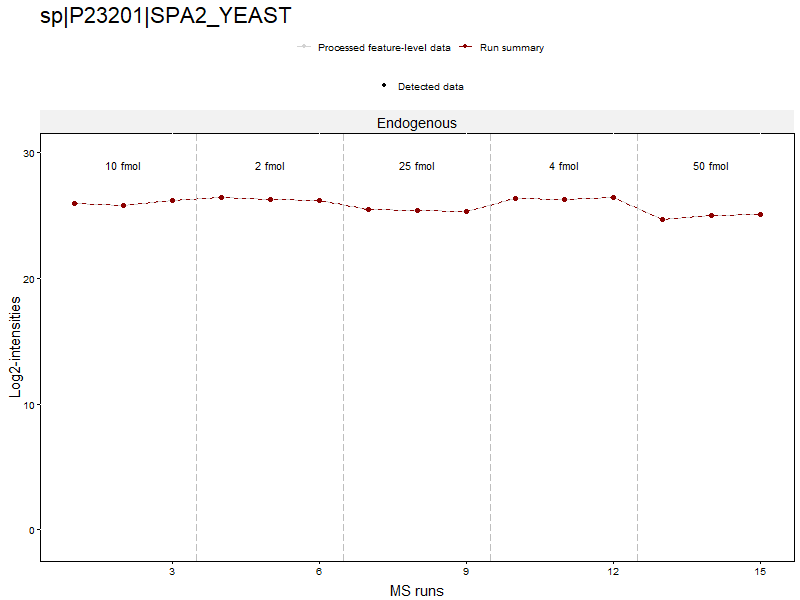

In [27]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |=                                                                     |   1%


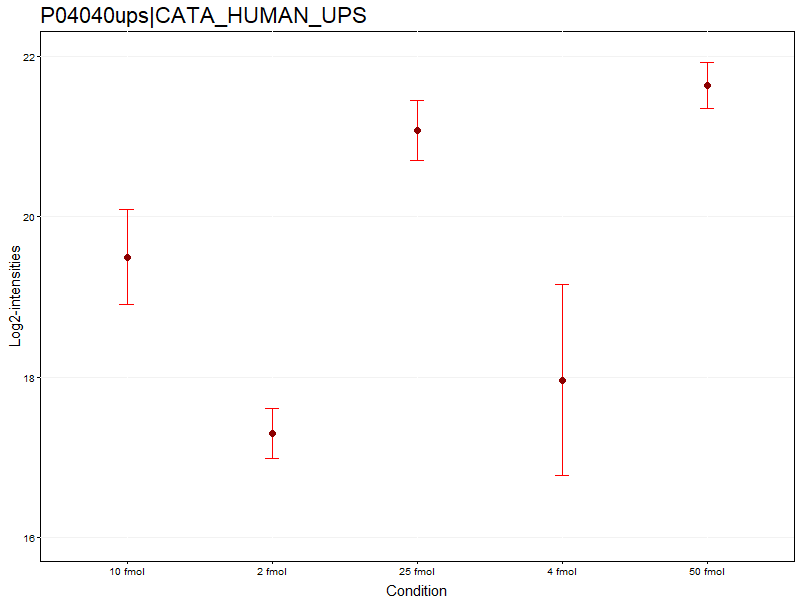

In [28]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("P04040ups|CATA_HUMAN_UPS", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [32]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,-1,0,0,-1,0,0,1,1,0,0,0,0,-1,0,0,-1,0,-1,-1,-1,0,0,0,1,1,1,0,0,0,0,0,-1,0,0,-1,0,-1,0,1,1,1,1,1,0,0,0,0,0,0)
comparison <- matrix(comparison_matrix, nrow=10)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", 
                          "10vs2", "4vs2")
print(comparison)

[1] "10 fmol" "2 fmol"  "25 fmol" "4 fmol"  "50 fmol"
       10 fmol 2 fmol 25 fmol 4 fmol 50 fmol
50vs25       0      0      -1      0       1
50vs10      -1      0       0      0       1
50vs4        0      0       0     -1       1
50vs2        0     -1       0      0       1
25vs10      -1      0       1      0       0
25vs4        0      0       1     -1       0
25vs2        0     -1       1      0       0
10vs4        1      0       0     -1       0
10vs2        1     -1       0      0       0
4vs2         0     -1       0      1       0


In [33]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-12-02 21:49:51]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-12-02 21:50:08]  == Comparisons for all proteins are done.


### Measure Accuracy of protein quantification

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected FC - experimental FC / expected FC) * 100. N=number of UPS1 quantified proteins

In [4]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,50vs25,0.738544,0.309611,2.385390,10.0,3.825863e-02,1.394082e-01,NaN,0.231481,0.231481
1,O00762ups|UBE2C_HUMAN_UPS,50vs10,2.170214,0.309611,7.009481,10.0,3.673366e-05,5.229424e-04,NaN,0.361111,0.361111
2,O00762ups|UBE2C_HUMAN_UPS,50vs4,4.698741,0.309611,15.176262,10.0,3.124856e-08,1.925263e-06,NaN,0.527778,0.527778
3,O00762ups|UBE2C_HUMAN_UPS,50vs2,5.218870,0.309611,16.856206,10.0,1.134062e-08,9.951390e-07,NaN,0.546296,0.546296
4,O00762ups|UBE2C_HUMAN_UPS,25vs10,1.431670,0.309611,4.624091,10.0,9.446630e-04,1.614401e-02,NaN,0.444444,0.444444


[32.93142918997399, 33.612972131363826, 35.40515231810427, 45.141201233968204, 13.66208005405145, 34.75479830041817, 37.79595758852114, 24.12666043077941, 27.466090053450266, 22.57283709039108]


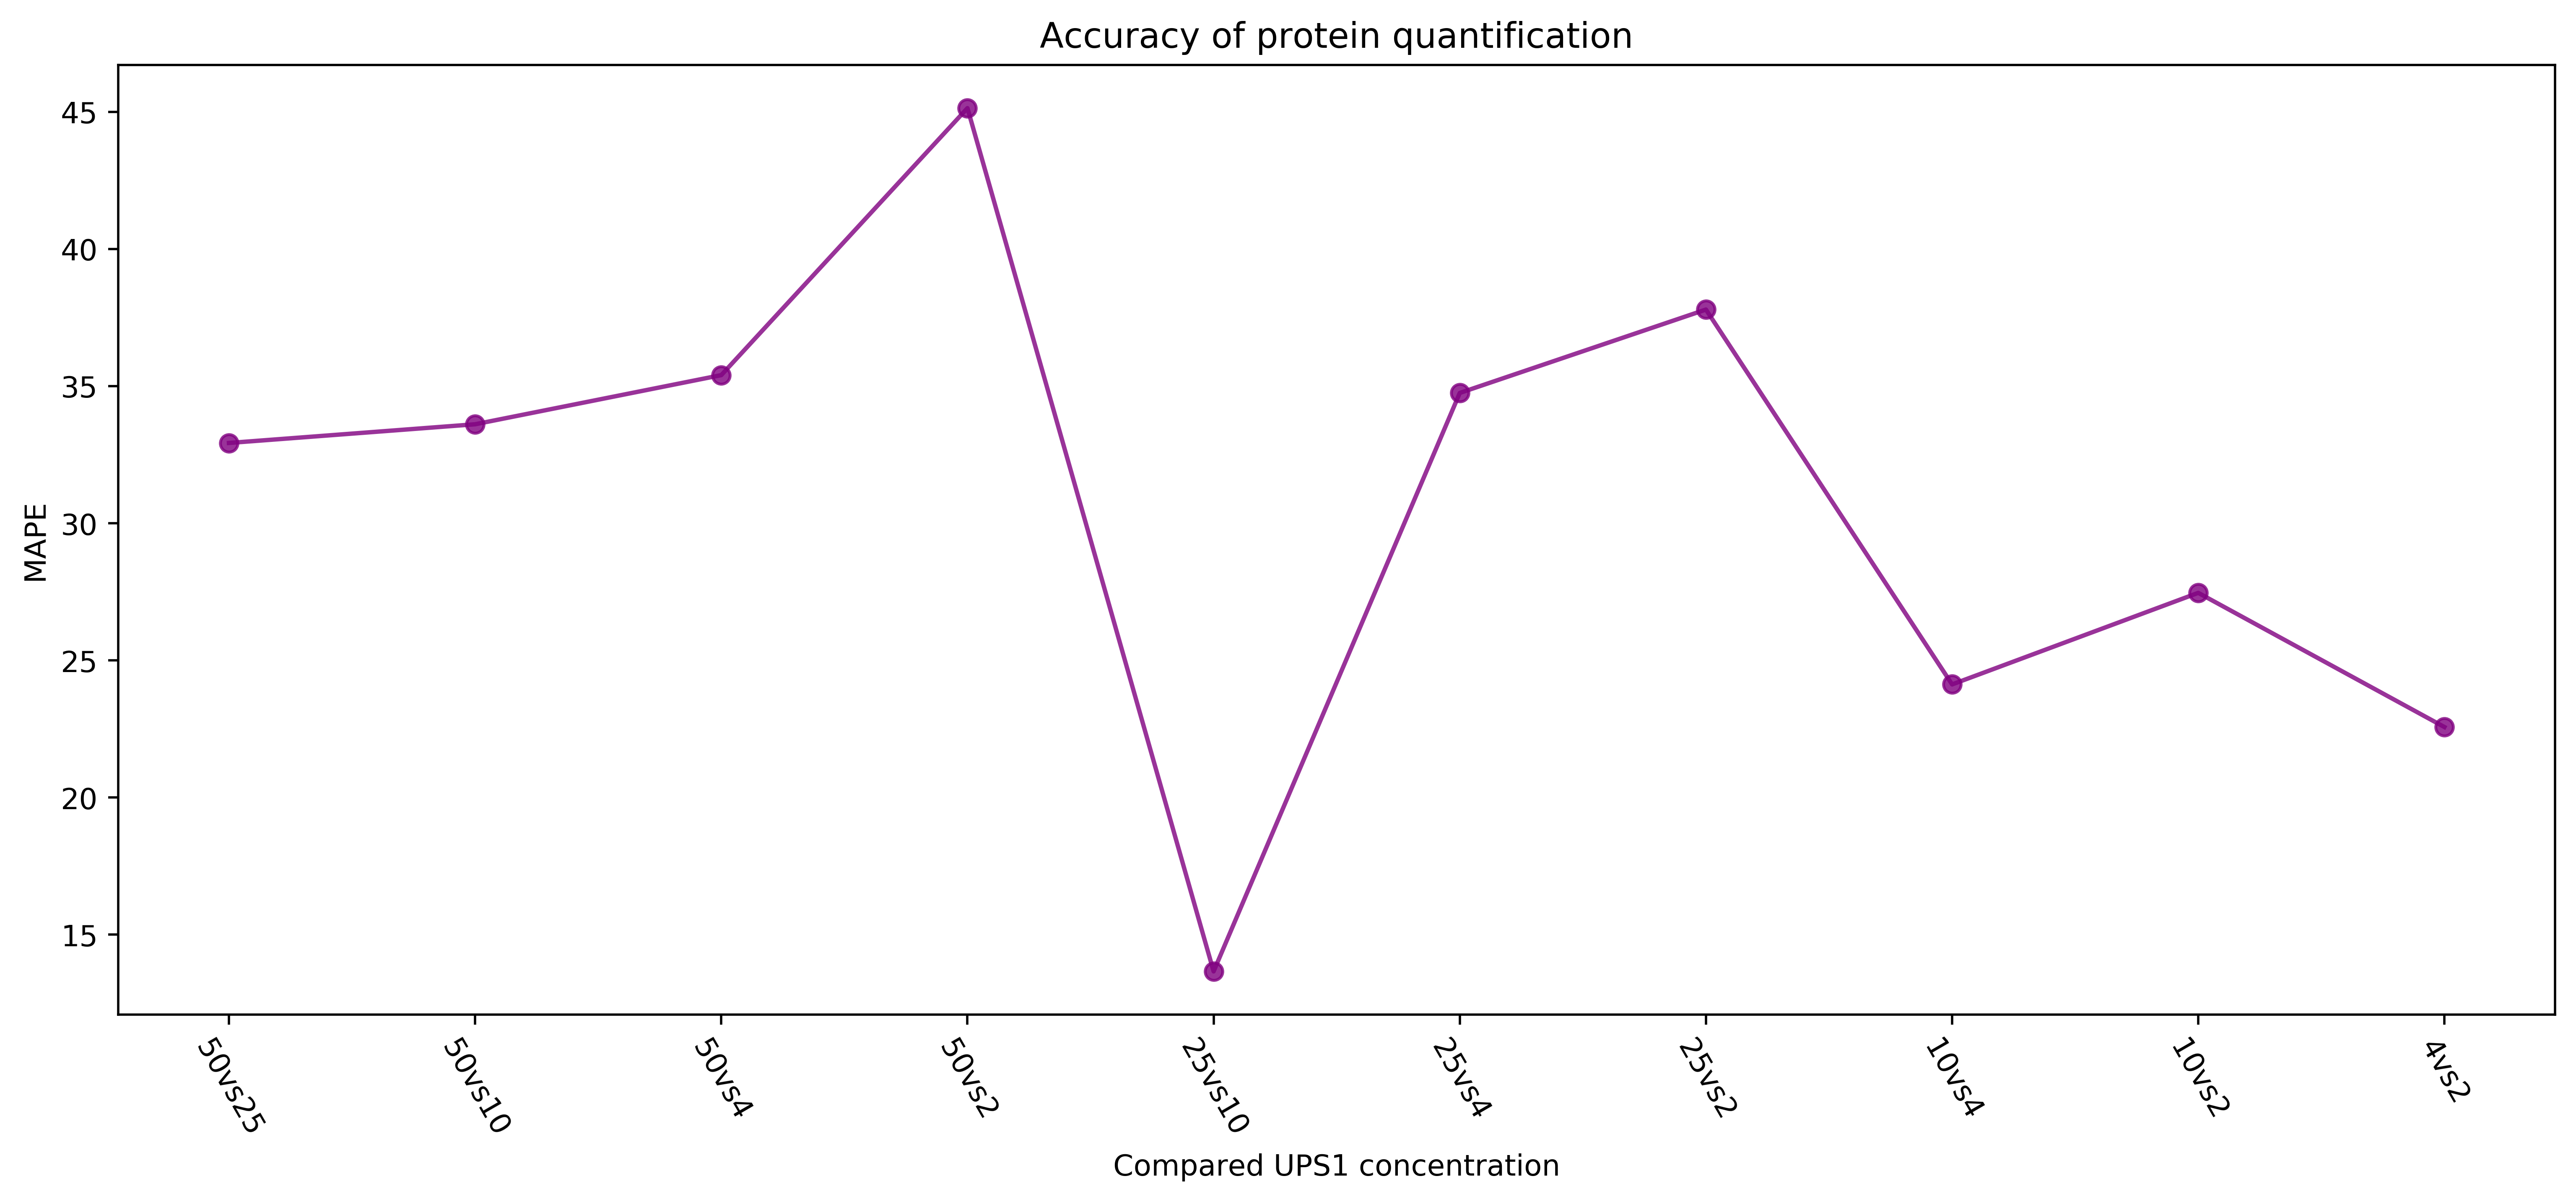

In [35]:
# calculate MAPE
import math

MAPE = []
ups_comp = compar_res[compar_res['Protein'].str.contains("UPS")]
conditions = ["50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", 
                          "10vs2", "4vs2"]
for condition in conditions:
    t = ups_comp[ups_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        experimental_FC = math.pow(2, t[t['Protein'] == protein]['log2FC'])
        expected_FC = float(condition.split("vs")[0]) / float(condition.split("vs")[1])
        ape.append(np.abs(expected_FC - experimental_FC) / expected_FC * 100)
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(10), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(10), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared UPS1 concentration")
plt.ylabel("MAPE")
plt.xticks(rotation=300)
plt.show()

#### The MSE of the logFC estimates in the all two-group comparisons

0.1681868650744473
0.2506565795349214
0.35045693526239535
0.6093065020088874


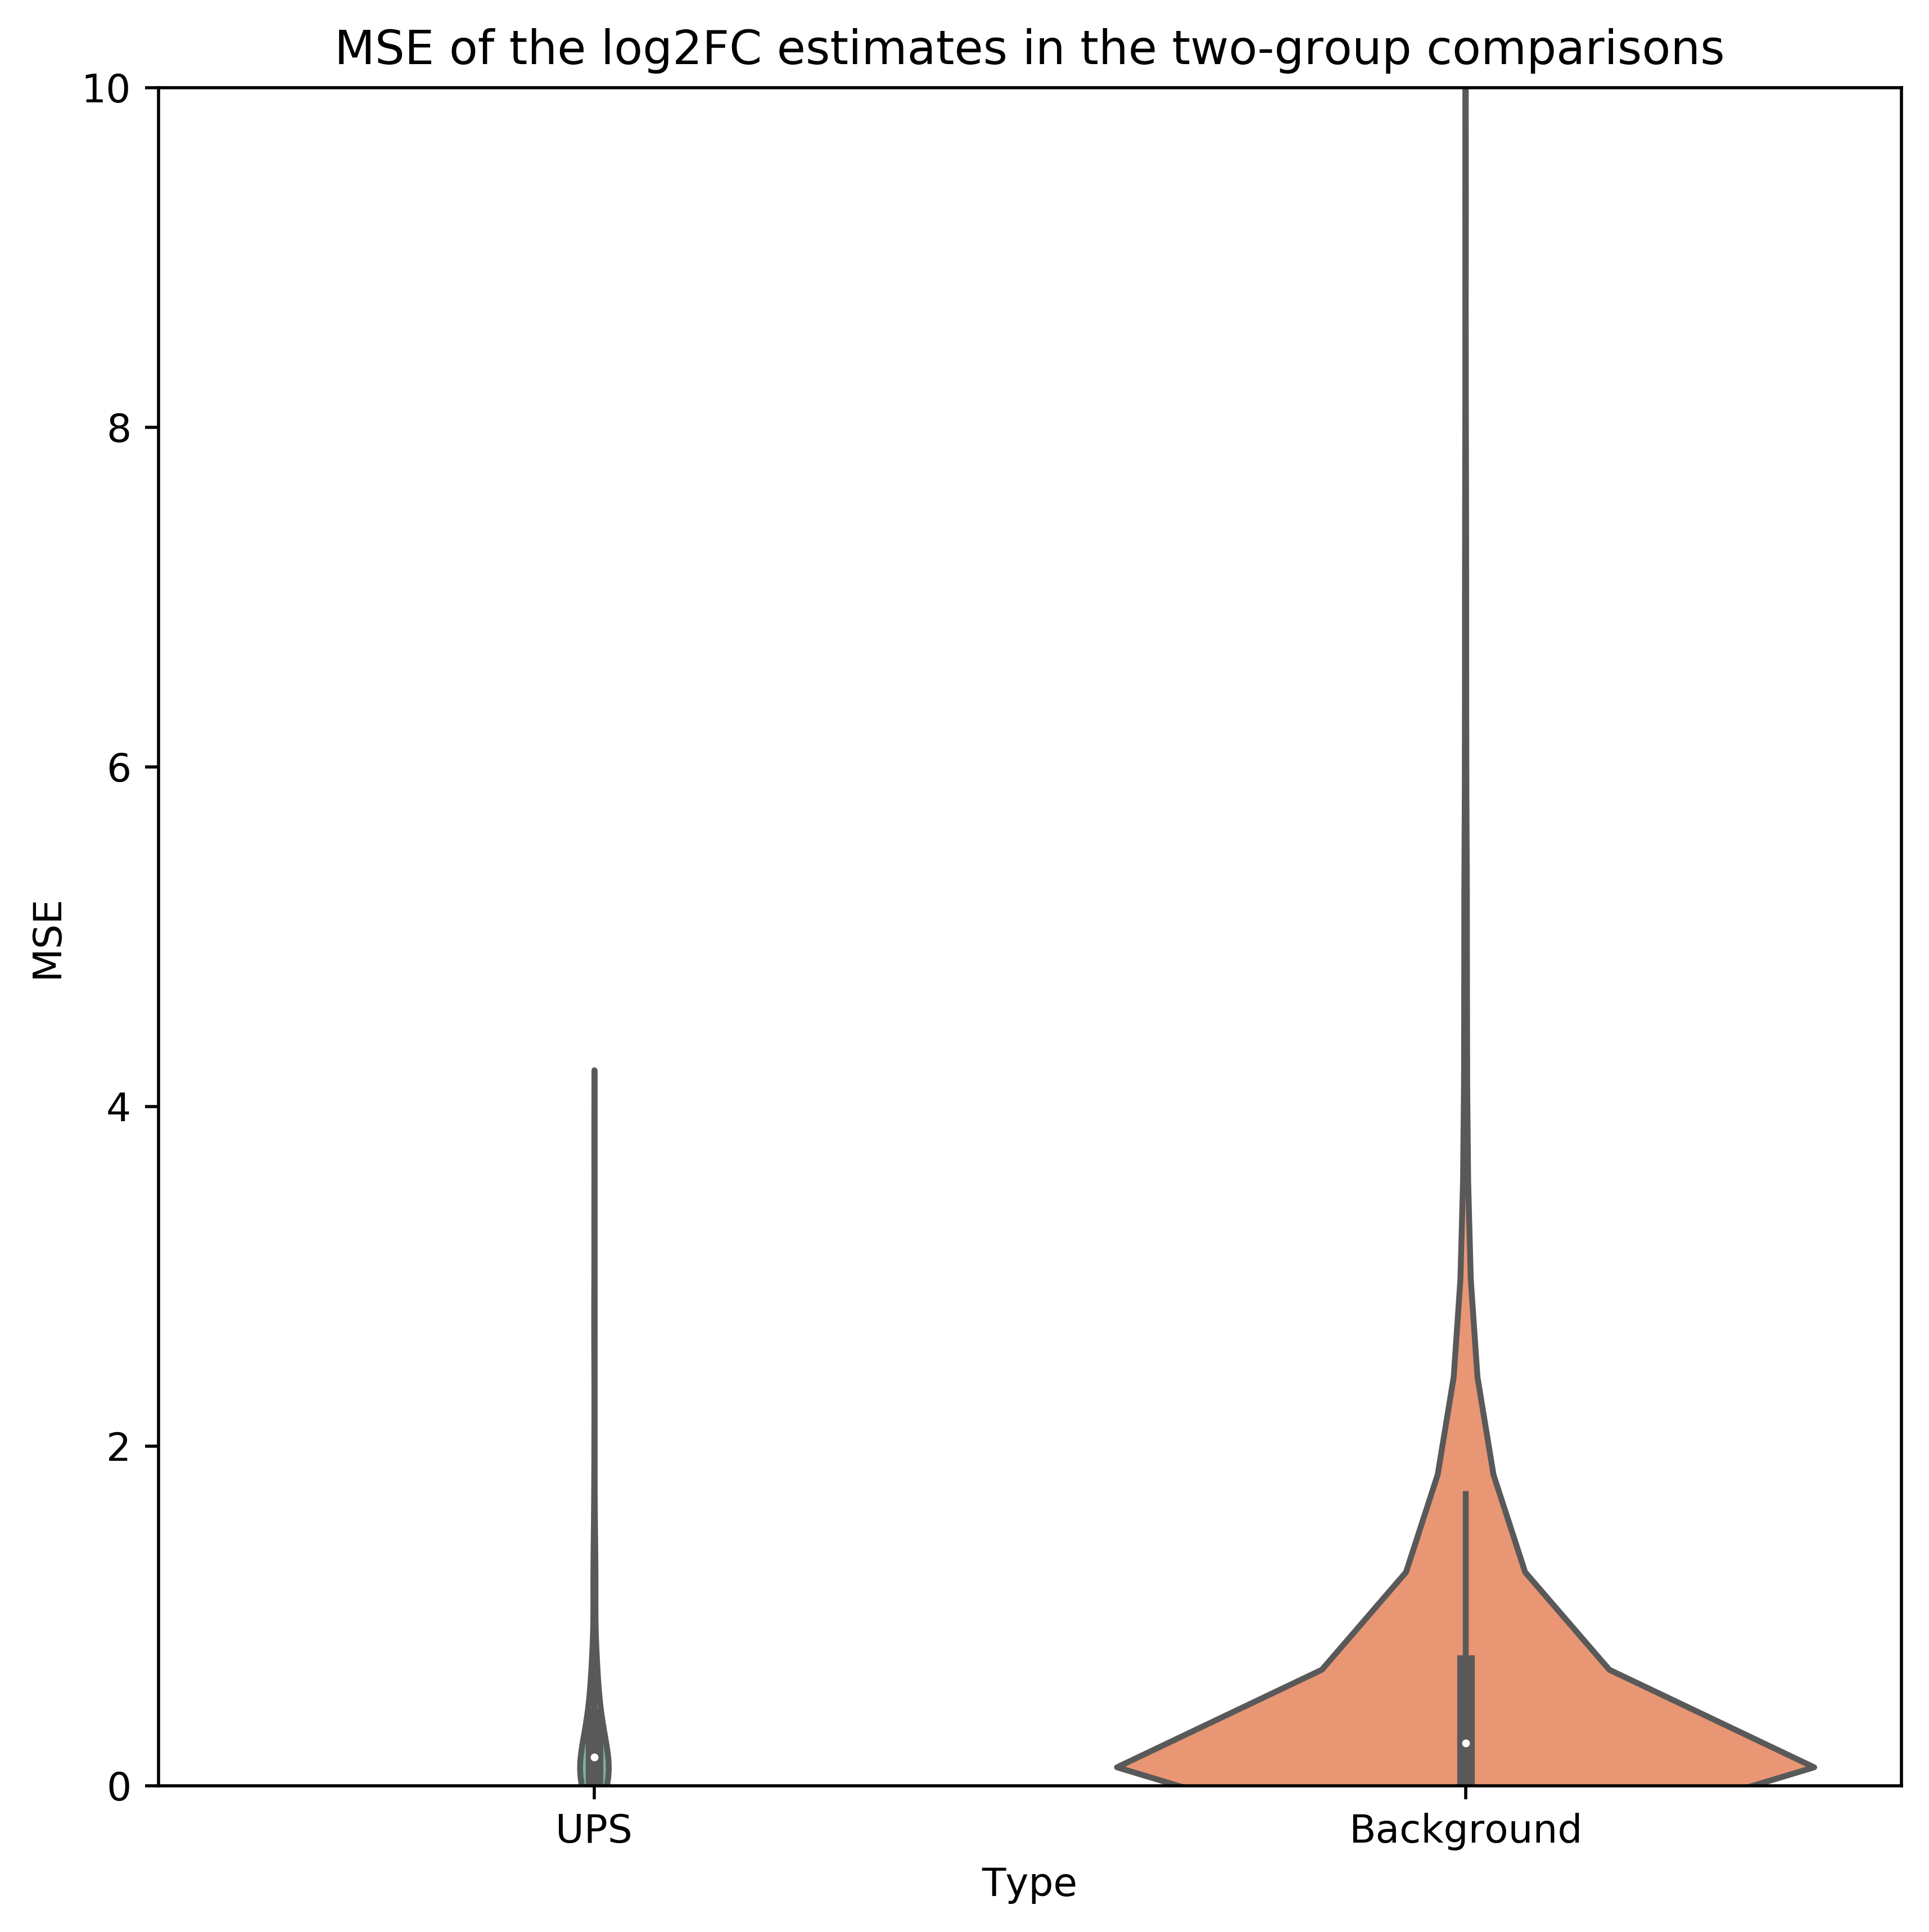

In [5]:
MSEs = pd.DataFrame(columns=["Type", "MSE"])

for _, row in compar_res.iterrows():
    if "Missing" in str(row['issue']):
        continue
    experimental_log2FC = row['log2FC']
    condition = row['Label']
    if "UPS" in row['Protein']:
        datatype = "UPS"
        expected_log2FC = np.log2(float(condition.split("vs")[0]) / float(condition.split("vs")[1]))
    else:
        expected_log2FC = 0
        datatype = "Background"
    mse = (experimental_log2FC - expected_log2FC) ** 2
    MSEs = MSEs.append({'Type': datatype, "MSE": mse}, ignore_index=True)
    
plt.figure(figsize=(8,8), dpi=500)
plt.ylim(0, 10)
plt.title("MSE of the log2FC estimates in the two-group comparisons")
sns.violinplot(x = "Type", y="MSE", data=MSEs, scale= "count", palette="Set2")
print(np.median(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.median(MSEs[MSEs['Type'] != "UPS"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] != "UPS"]['MSE']))
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)；Specifity = TNR = TN / (TN + FN)

In [4]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('(issue != issue) & (pvalue == pvalue)')
compar_res

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,50vs25,0.738544,0.309611,2.385390,10.0,3.825863e-02,1.394082e-01,NaN,0.231481,0.231481
1,O00762ups|UBE2C_HUMAN_UPS,50vs10,2.170214,0.309611,7.009481,10.0,3.673366e-05,5.229424e-04,NaN,0.361111,0.361111
2,O00762ups|UBE2C_HUMAN_UPS,50vs4,4.698741,0.309611,15.176262,10.0,3.124856e-08,1.925263e-06,NaN,0.527778,0.527778
3,O00762ups|UBE2C_HUMAN_UPS,50vs2,5.218870,0.309611,16.856206,10.0,1.134062e-08,9.951390e-07,NaN,0.546296,0.546296
4,O00762ups|UBE2C_HUMAN_UPS,25vs10,1.431670,0.309611,4.624091,10.0,9.446630e-04,1.614401e-02,NaN,0.444444,0.444444
5,O00762ups|UBE2C_HUMAN_UPS,25vs4,3.960197,0.309611,12.790872,10.0,1.599431e-07,1.036964e-05,NaN,0.611111,0.611111
6,O00762ups|UBE2C_HUMAN_UPS,25vs2,4.480327,0.309611,14.470815,10.0,4.935015e-08,5.113864e-06,NaN,0.629630,0.629630
7,O00762ups|UBE2C_HUMAN_UPS,10vs4,2.528527,0.309611,8.166781,10.0,9.823643e-06,5.420602e-04,NaN,0.740741,0.740741
8,O00762ups|UBE2C_HUMAN_UPS,10vs2,3.048657,0.309611,9.846725,10.0,1.830969e-06,1.919466e-04,NaN,0.759259,0.759259
9,O00762ups|UBE2C_HUMAN_UPS,4vs2,0.520129,0.309611,1.679943,10.0,1.238893e-01,9.998339e-01,NaN,0.925926,0.925926


#### ROC curve

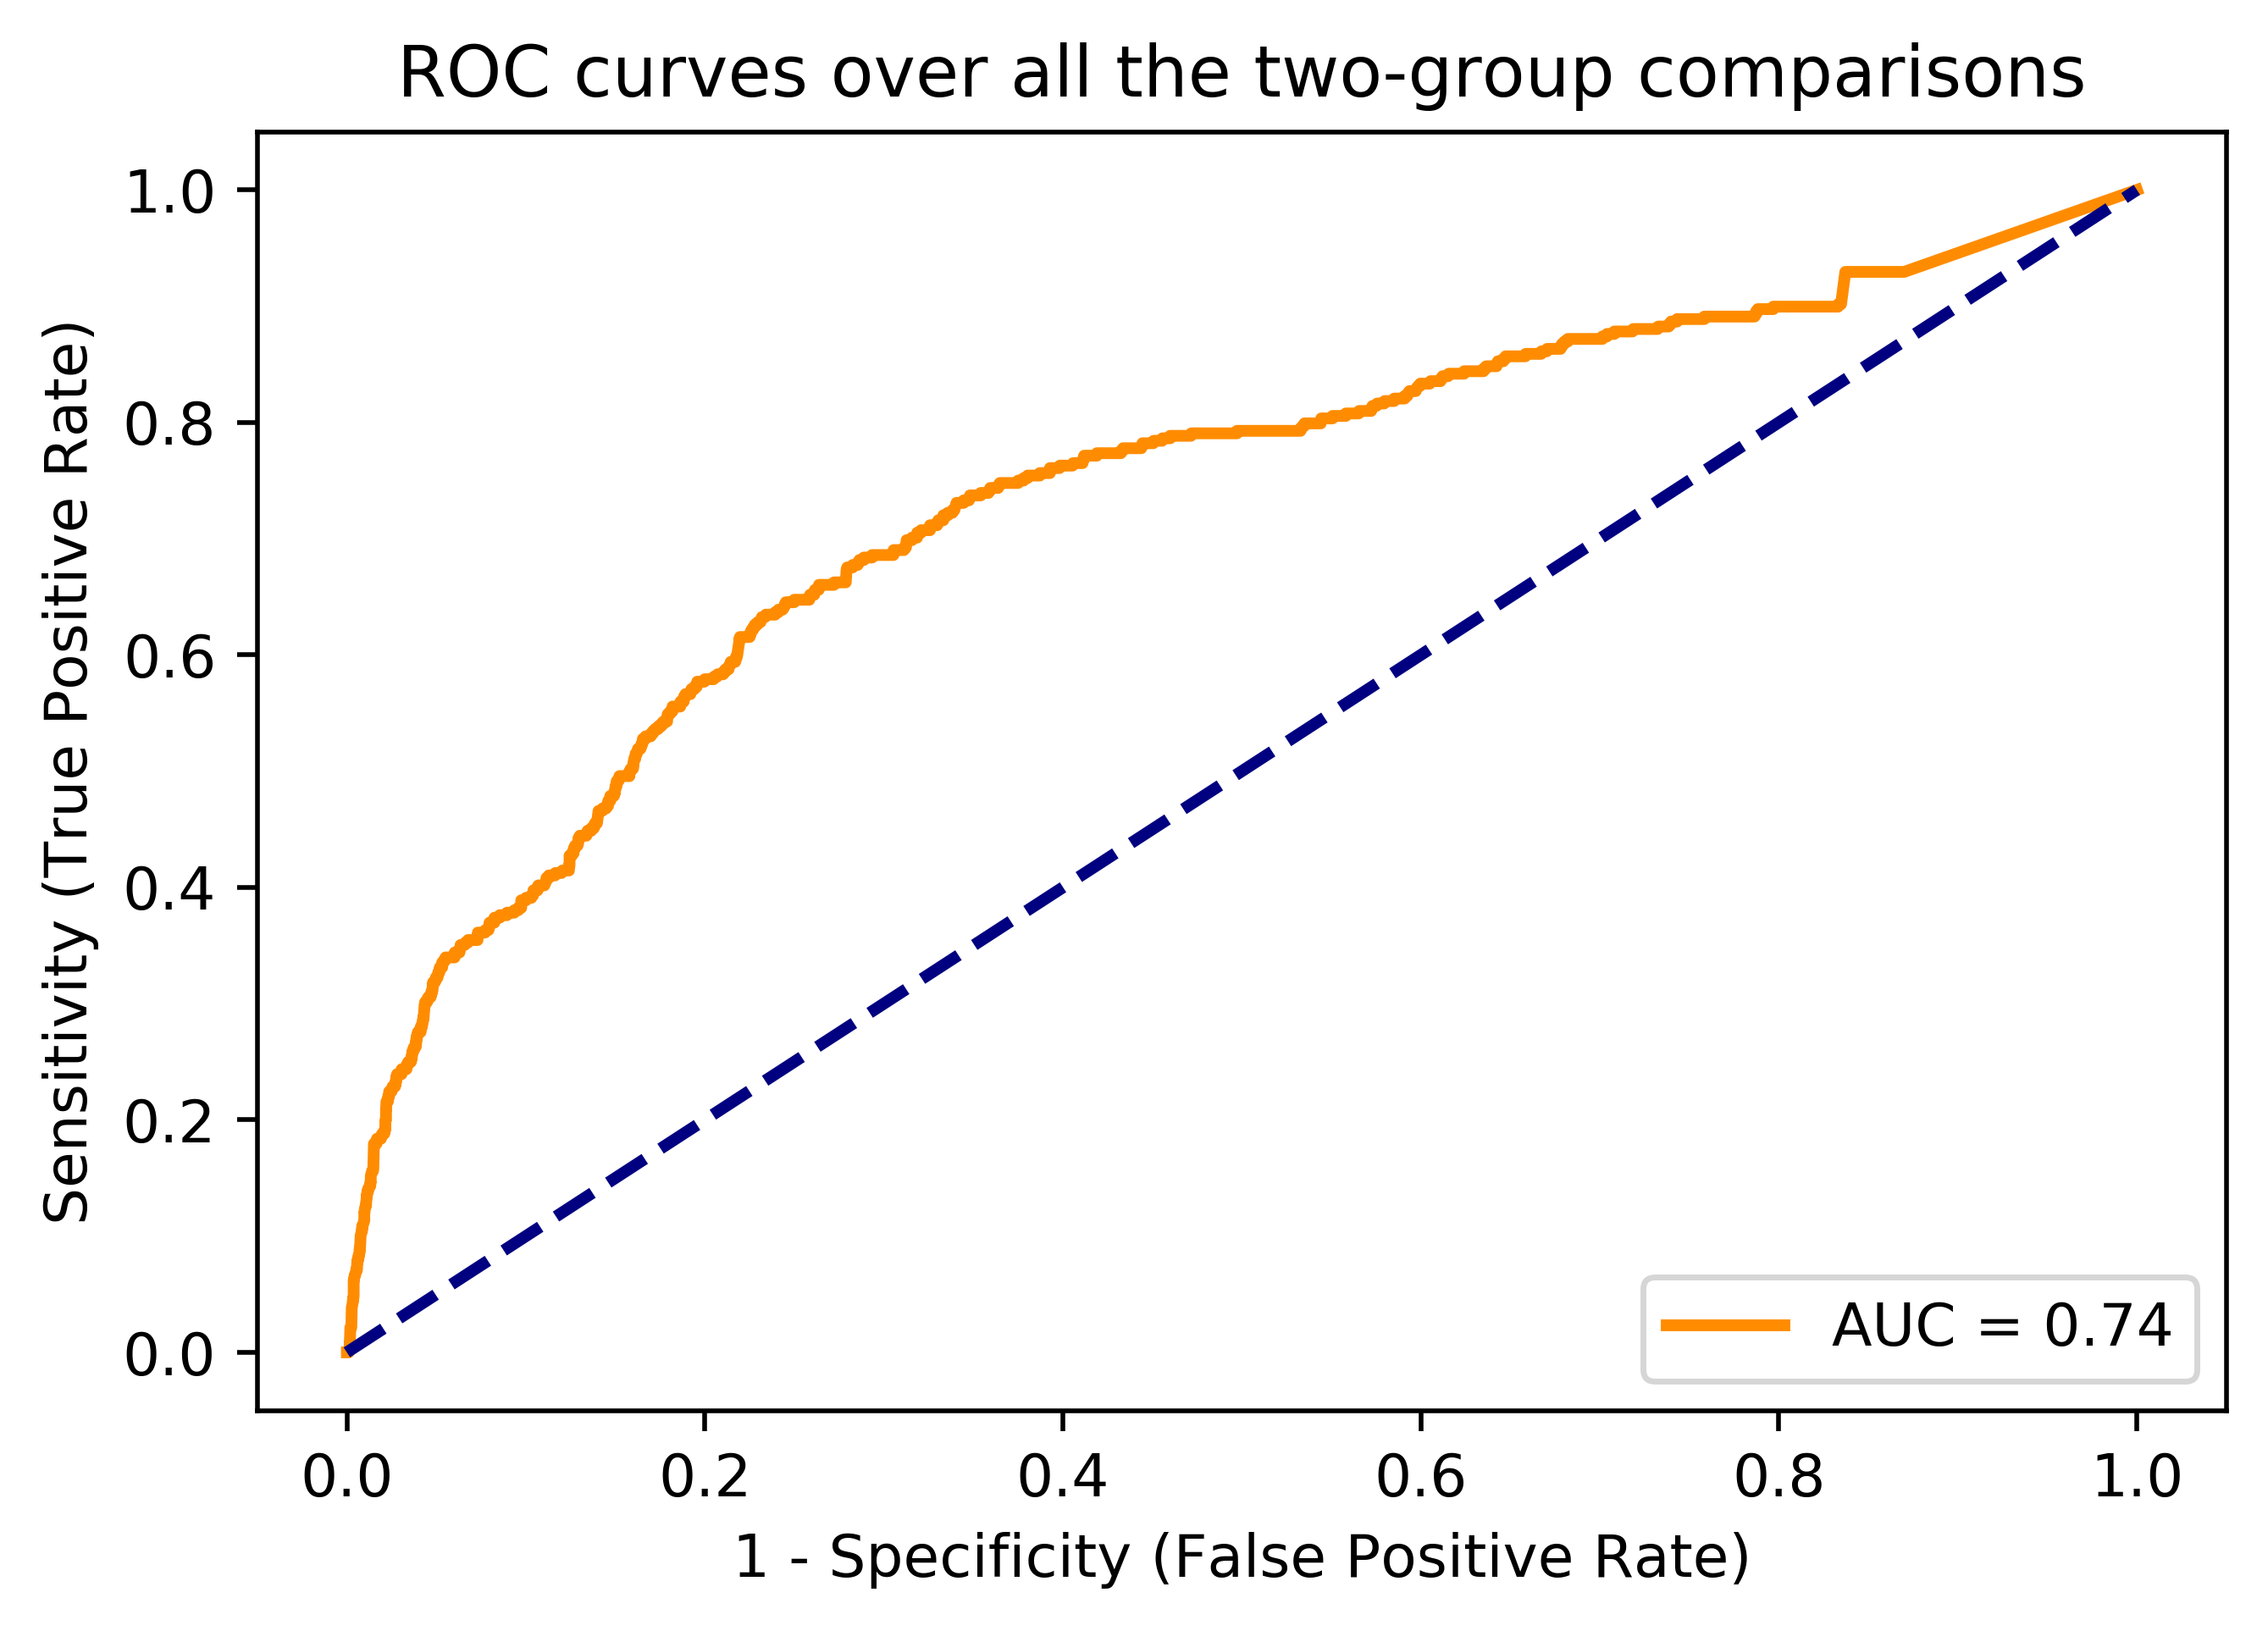

In [5]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['adj.pvalue']
compar_res['y'] = compar_res['Protein'].map(lambda x: ("UPS" in x and 1) or ("UPS" not in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")


#### pAUCs within each comparison

Text(0.5, 1.0, 'pAUCs of each two-group comparison')

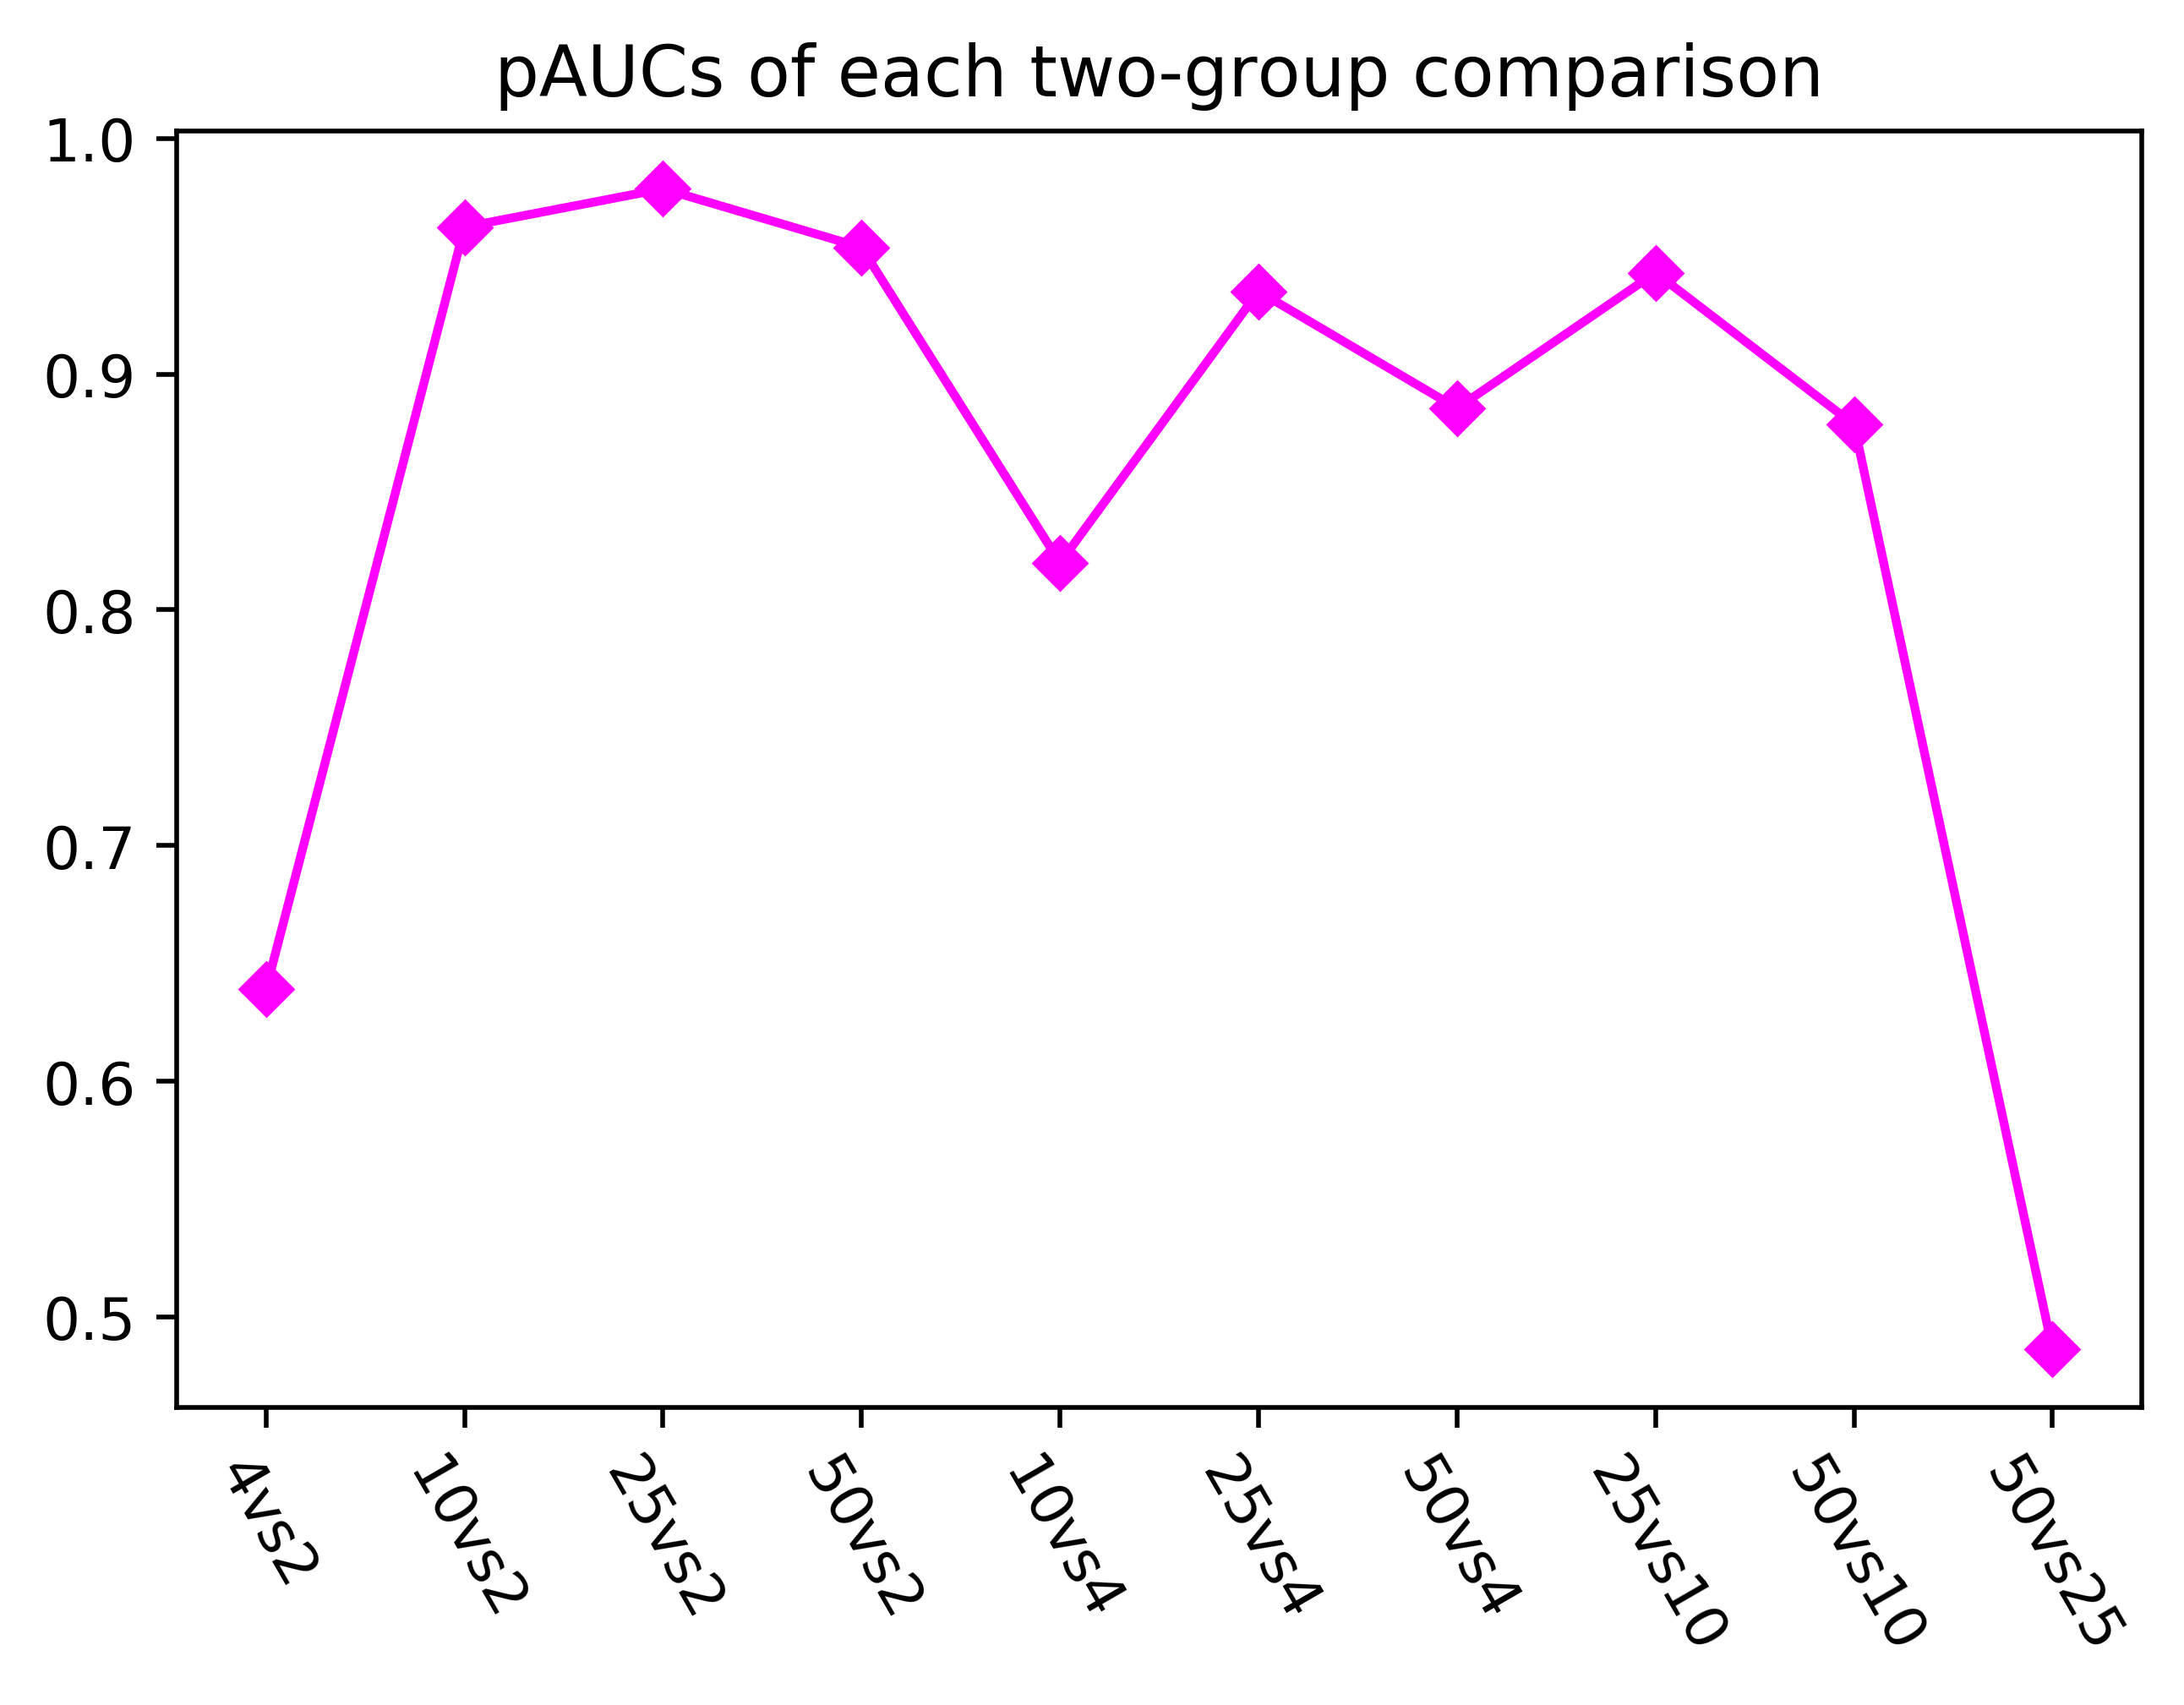

In [6]:
compar_res.head()

conditions = ["4vs2", "10vs2", "25vs2", "50vs2", "10vs4", "25vs4", "50vs4", "25vs10", "50vs10", "50vs25"]
paucs = []
for condition in conditions:
    comp_condition = compar_res[compar_res['Label'] == condition]
    fpr, tpr, thresholds = metrics.roc_curve(comp_condition['y'].tolist(), comp_condition['value'].tolist(), pos_label = 1)
    pauc = metrics.auc(fpr, tpr)
    paucs.append(pauc)

plt.figure(dpi=500)
plt.plot(range(10), paucs, 'rD-', color='magenta')
plt.xticks(range(10), conditions)
plt.xticks(rotation=300)

plt.title("pAUCs of each two-group comparison")


In [37]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", "10vs2", "4vs2"]

data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (group['Protein'].str.contains("UPS"))])
    TP = len(differential_proteins[differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    FP = len(differential_proteins[-differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)

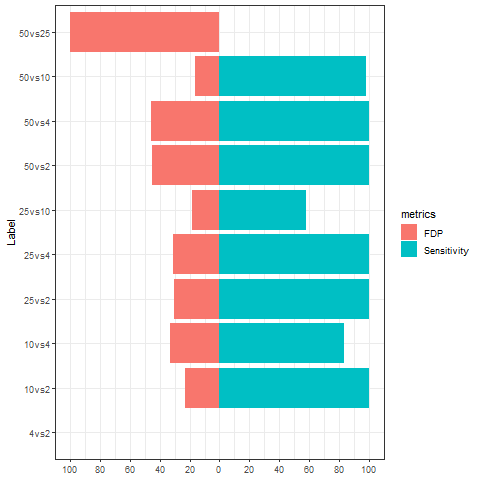

In [38]:
%%R 

library(ggplot2)
data = read.csv("test1.csv", sep=',',header = TRUE)
conditions = c("50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", 
                          "10vs2", "4vs2")

conditions = rev(conditions)
data$Label <- factor(data$Label,levels=conditions)

ggplot(data = data) + geom_col(aes(x = Label, y = value2, fill = metrics)) + 
   scale_y_continuous(breaks = seq(from = -100, to = 100,by = 20),labels = c(seq(100, 0, -20), seq(20, 100, 20))) + 
   coord_flip() + theme_bw() + ylab(NULL)

# ggsave("sensitivity.png", dpi = 500)